In [33]:
# Looking into performance of unweighted model
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load FinBERT (Hugging Face model)
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

labels = ["negative", "neutral", "positive"]

def predict_finbert(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1).squeeze()
    pred_class = torch.argmax(probs).item()
    return {
        "text": text,
        "prediction": labels[pred_class],
        "confidence": float(probs[pred_class])
    }

# Example
print(predict_finbert("The bank resolved my issue quickly and politely."))
print(predict_finbert("Terrible experience, my loan was delayed for weeks."))
print(predict_finbert("Bad Customer support"))



{'text': 'The bank resolved my issue quickly and politely.', 'prediction': 'negative', 'confidence': 0.8156914114952087}
{'text': 'Terrible experience, my loan was delayed for weeks.', 'prediction': 'positive', 'confidence': 0.962162971496582}
{'text': 'Bad Customer support', 'prediction': 'negative', 'confidence': 0.9862933158874512}


In [16]:
df = pd.read_csv('bank_reviews.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   author                996 non-null    object 
 1   date                  1000 non-null   object 
 2   address               1000 non-null   object 
 3   bank                  1000 non-null   object 
 4   rating                1000 non-null   float64
 5   review_title_by_user  1000 non-null   object 
 6   review                1000 non-null   object 
 7   bank_image            1000 non-null   object 
 8   rating_title_by_user  1000 non-null   object 
 9   useful_count          1000 non-null   int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 78.3+ KB


In [35]:
# Testing unweighted model on customer reviews
df['predicted_label'] = df['review'].apply(lambda x: predict_finbert(x)['prediction'])


In [37]:
df['predicted_label'].value_counts(dropna = False)

predicted_label
neutral     944
positive     56
Name: count, dtype: int64

In [17]:
df = df[['review','rating']]
df.head()

review  rating
0  State Bank Of India is located nearby in our a...     4.0
1  I have my salary account in SBI, when I applie...     5.0
2  I am using Axis bank saving account for the  p...     5.0
3  I have my salary bank account in HDFC bank for...     5.0
4  Close to around 10 years, I am holding this Co...     5.0

In [18]:
df['rating'].value_counts(dropna = False)

rating
5.0    550
4.0    257
3.0     71
4.5     45
2.0     30
3.5     21
1.0     13
0.5     10
2.5      2
1.5      1
Name: count, dtype: int64

In [19]:
# create rating class
def bin(rating):
    if rating > 0 and rating < 3:
        return 'negative'
    elif rating >= 3 and rating < 4:
        return 'neutral'
    else:
        return 'positive'


In [20]:
df['rating_class'] = df['rating'].apply(bin)


In [21]:
df['rating_class'].value_counts(dropna = False)

rating_class
positive    852
neutral      92
negative     56
Name: count, dtype: int64

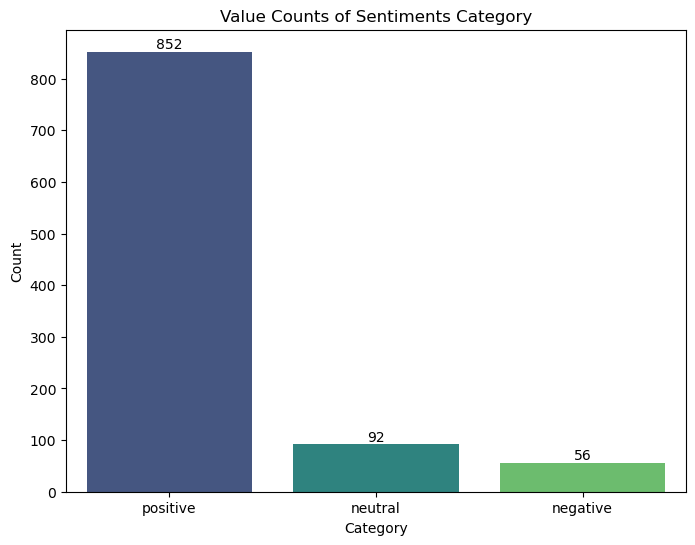

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create the countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='sentiment', palette='viridis')

# Add data labels to the bars
for container in ax.containers:
    ax.bar_label(container)

plt.title('Value Counts of Sentiments Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [22]:
df = df[['review','rating_class']]
df.head()

review rating_class
0  State Bank Of India is located nearby in our a...     positive
1  I have my salary account in SBI, when I applie...     positive
2  I am using Axis bank saving account for the  p...     positive
3  I have my salary bank account in HDFC bank for...     positive
4  Close to around 10 years, I am holding this Co...     positive

In [23]:
# rename columns
df.rename(columns={
    'review': 'sentence',
    'rating_class': 'sentiment'
}, inplace=True)

In [29]:
df['label']

0      0
1      0
2      0
3      0
4      0
      ..
995    2
996    0
997    0
998    0
999    0
Name: label, Length: 1000, dtype: int64


Model and tokenizer saved to: ./models2/finbert-financial-sentiment



Classification Report:

              precision    recall  f1-score   support

    positive       0.85      1.00      0.92       170
    negative       0.00      0.00      0.00        11
     neutral       0.00      0.00      0.00        19

    accuracy                           0.85       200
   macro avg       0.28      0.33      0.31       200
weighted avg       0.72      0.85      0.78       200



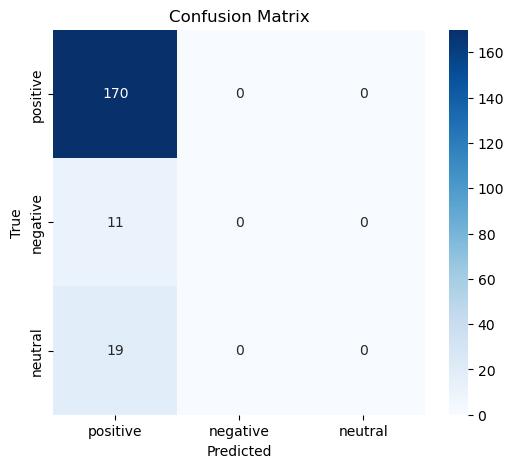

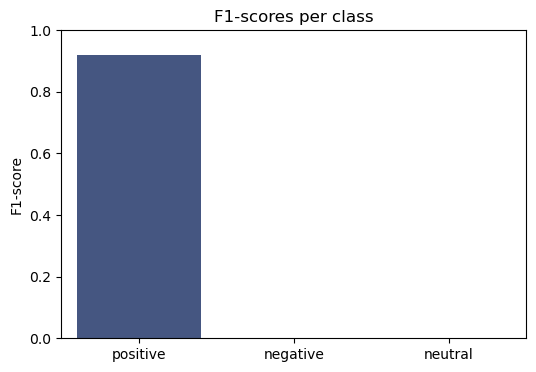

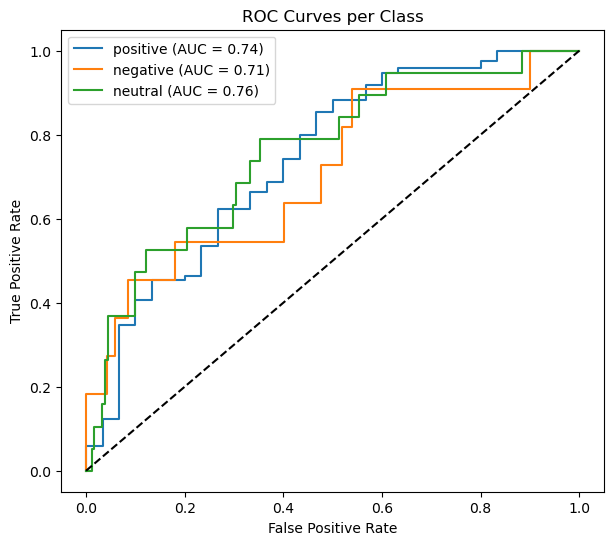


Example Inference → profit up
Predicted Sentiment: negative


In [28]:
# ============================================================
# Sentiment Analysis for Banking Texts using FinBERT
# Dataset: Financial PhraseBank (100% Agreement version)
# Optimized for CPU with metrics & plots (incl. ROC/AUC)
# ============================================================

import warnings
warnings.filterwarnings('ignore')

# Import libraries
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments
)
import evaluate
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Use all available CPU threads
torch.set_num_threads(torch.get_num_threads())

# ============================================================
# Load dataset
# ============================================================
#df = pd.read_csv(
#    "../datasets/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt",
#    sep="@", header=None, encoding="latin-1",
#    names=["sentence", "sentiment"]
#)


# Encode labels
label_map = {"positive": 0, "negative": 1, "neutral": 2}
df["label"] = df["sentiment"].map(label_map)

# Train/test split
#train_texts, test_texts, train_labels, test_labels = train_test_split(
#    df["sentence"].tolist(),
#    df["label"].tolist(),
#    test_size=0.2,
#    random_state=42, stratify=['label']
#)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["sentence"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)



# ============================================================
# Tokenization (limit sequence length to 128 for speed)
# ============================================================
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

# ============================================================
# Dataset class for Trainer
# ============================================================
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_ds = SentimentDataset(train_encodings, train_labels)
test_ds = SentimentDataset(test_encodings, test_labels)

# ============================================================
# Load pre-trained FinBERT model
# ============================================================
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# ============================================================
# Define metrics
# ============================================================
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return metric.compute(predictions=preds, references=labels)

# ============================================================
# Training arguments (CPU-optimized)
# ============================================================
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=20
)

# ============================================================
# Trainer
# ============================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# ============================================================
# Train model
# ============================================================
trainer.train()

# ============================================================
# Save final model with clear name
# ============================================================
save_path = "./models2/finbert-financial-sentiment"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"\nModel and tokenizer saved to: {save_path}")

# ============================================================
# Evaluate with detailed metrics
# ============================================================
predictions = trainer.predict(test_ds)
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids
y_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["positive", "negative", "neutral"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["positive", "negative", "neutral"],
            yticklabels=["positive", "negative", "neutral"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Bar chart for F1-scores
report = classification_report(y_true, y_pred, target_names=["positive", "negative", "neutral"], output_dict=True)
f1_scores = [report[label]["f1-score"] for label in ["positive", "negative", "neutral"]]

plt.figure(figsize=(6,4))
sns.barplot(x=["positive", "negative", "neutral"], y=f1_scores, palette="viridis")
plt.title("F1-scores per class")
plt.ylabel("F1-score")
plt.ylim(0,1)
plt.show()

# ============================================================
# ROC / AUC curves for each class
# ============================================================
n_classes = 3
y_true_bin = label_binarize(y_true, classes=[0,1,2])

plt.figure(figsize=(7,6))
for i, label in enumerate(["positive", "negative", "neutral"]):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class")
plt.legend()
plt.show()

# ============================================================
# Inference on new text
# ============================================================
text = "profit up"
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)
pred = torch.argmax(outputs.logits).item()

labels = ["positive", "negative", "neutral"]
print("\nExample Inference →", text)
print("Predicted Sentiment:", labels[pred])


In [30]:

# ============================================================
# Inference on new text
# ============================================================
text = "I really get good return from my investments last year"
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)
pred = torch.argmax(outputs.logits).item()

labels = ["negative", "neutral", "positive"]
print("\nExample Inference →", text)
print("Predicted Sentiment:", labels[pred])



Example Inference → I really get good return from my investments last year
Predicted Sentiment: negative
